In [1]:
%matplotlib inline

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import torch
import segmentation_models_pytorch as smp
import albumentations as albu

import seaborn as sns
import pylab as py
import pandas as pd

#### Dataset Preprocessing

In [2]:
class Dataset(BaseDataset):
    ''' Works for our fish dataset.
    This module will read image from the location/directory you have provided.
    This module can apply any default augmentation or can apply preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    '''
    
    # The label set this dataset has:    
    CLASSES = ['background', 'dorsal', 'adipose', 'caudal', 'anal', 
               'pelvic', 'pectoral', 'head', 'eye', 
               'caudal-ray', 'alt-ray', 'alt-spine', 'trunk']
    
    def __init__(self, images_dir, masks_dir=None, classes=None, augmentation=None, preprocessing=None,):
        
        # list all fils in images_dir folder
        self.ids = os.listdir(images_dir)
        
        
        # remove all non-image/non-mask files
        # self.images_fps contains image list
        # self.masks_fps contains mask list
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.images_fps = [items for items in self.images_fps if items[-4:]=='.png']
        
        if masks_dir is not None:
            self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
            self.masks_fps = [items for items in self.masks_fps if items[-4:]=='.png']
        
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        # initialize augmentation and preprocessing 
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.masks_dir = masks_dir
        
    def __getitem__(self, i):
        
        # this module will run for each image with index i
        
        # read the image
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read the mask
        if self.masks_dir is not None:
            mask = cv2.imread(self.masks_fps[i], 0)
        
        
            # separate channel for different masks -> [:, :, channel]
            masks = [(mask == v) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            if self.masks_dir is not None:
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            else:
                sample = self.augmentation(image=image)
                image = sample['image']
                mask = None
        
        # apply preprocessing
        if self.preprocessing:
            if self.masks_dir is not None:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            else:
                sample = self.preprocessing(image=image)
                image = sample['image']
                mask = None
            
        return image, mask
    
    
    def __len__(self):
        return len(self.images_fps)  

In [3]:
##### Assign the location of your datasets

DATA_DIR = '/raid/maruf/data-800/'

# train set
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

# validation set
x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')


# test set
x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

#### Helper functions

In [4]:
def read_file(filename):
    f = open(filename)
    names = f.readlines()
    fname = []
    for file in names:
        fname.append(file.replace('.png\n', '.png'))
    return fname

In [5]:
def plot_double_image(image_1, image_2, title_1=None, title_2=None):
    ''' This method plot two images side by side
    '''
    
    plt.figure(figsize=(16, 5))
    
    plt.subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    if title_1 != None:
        plt.title(title_1)
    plt.imshow(image_1)
    
    plt.subplot(1, 2, 2)
    plt.xticks([])
    plt.yticks([])
    if title_2 != None:
        plt.title(title_2)
    plt.imshow(image_2)
    plt.show()

In [6]:
def plot_triple_image(image_1, image_2, image_3, 
                      title_1=None, title_2=None, title_3=None):
    ''' This method plot two images side by side
    '''
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    if title_1 != None:
        plt.title(title_1)
    plt.imshow(image_1)
    
    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    if title_2 != None:
        plt.title(title_2)
    plt.imshow(image_2)
    plt.show()
    
    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    if title_3 != None:
        plt.title(title_3)
    plt.imshow(image_3)
    plt.show()

In [7]:
def get_color_img(mask, normal=True):
    ''' mask shape -> (320, 800, 12) if normal=True
    else: mask shape -> (12, 320, 800)
        we want to output a PIL image with rgb color value
    '''
    colors = {}                            #   Name         Label
    #                                      # ----------------------
    colors[0] = np.array([0, 0, 0])        # Background      0
    colors[1] = np.array([254, 0, 0])      # Dorsal Fin      1
    colors[2] = np.array([0, 254, 0])      # Adipos Fin      2
    colors[3] = np.array([0, 0, 254])      # Caudal Fin      3
    colors[4] = np.array([254, 254, 0])    # Anal Fin        4
    colors[5] = np.array([0, 254, 254])    # Pelvic Fin      5
    colors[6] = np.array([254, 0, 254])    # Pectoral Fin    6
    colors[7] = np.array([254, 254, 254])  # Head            7
    colors[8] = np.array([0, 254, 102])    # Eye             8
    colors[9] = np.array([254, 102, 102])  # Caudal Fin Ray  9
    colors[10] = np.array([254, 102, 204]) # Alt Fin Ray     10
    colors[11] = np.array([254, 204, 102]) # Alt Fin Spine   11
    colors[12] = np.array([0, 124, 124])   # Trunk           12
    
    if normal == True:
        color_data = np.zeros((mask.shape[0], \
                               mask.shape[1], 3)).astype(np.uint8)

        for ch in range(0, mask.shape[2]):
            if mask[:, :, ch].sum() == 0:
                continue
            else:
                row_, col_ = np.where(mask[:, :, ch] == 1)
                color_data[row_, col_] = colors[ch+1]

        img_ = Image.fromarray(color_data)

        
        return img_
    
    else:
        color_data = np.zeros((mask.shape[1], \
                               mask.shape[2], 3)).astype(np.uint8)

        for ch in range(0, mask.shape[0]):
            if mask[ch, :, :].sum() == 0:
                continue
            else:
                row_, col_ = np.where(mask[ch, :, :] == 1)
                color_data[row_, col_] = colors[ch+1]
        img_ = Image.fromarray(color_data)
        
        
        return img_
        

In [8]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst 

#### Visualize the Dataset class output without any augmentation 

(320, 800, 3) (320, 800, 12)


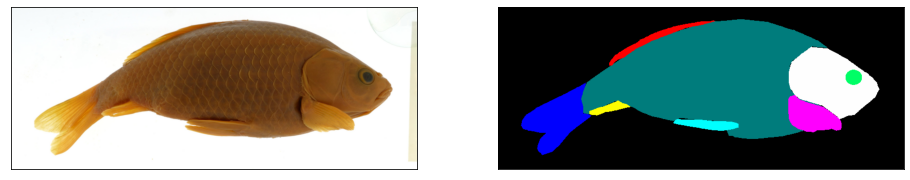

In [9]:
# temporary dataset variable
# we will look at the training set
dataset = Dataset(x_train_dir, 
                  y_train_dir,
                 classes = ['dorsal', 'adipose', 'caudal', 'anal', 
                            'pelvic', 'pectoral', 'head', 'eye', 
                            'caudal-ray', 'alt-ray', 'alt-spine', 'trunk'])

# Let's see the image and corresponding mask
image, mask = dataset[0]

print(image.shape, mask.shape)
plot_double_image(image, get_color_img(mask))

#### Augmentation from literature

In [10]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
########         albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(320, 800)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_preprocessing_unlabeled(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)


#### Visualize the Dataset class output with augmentation 

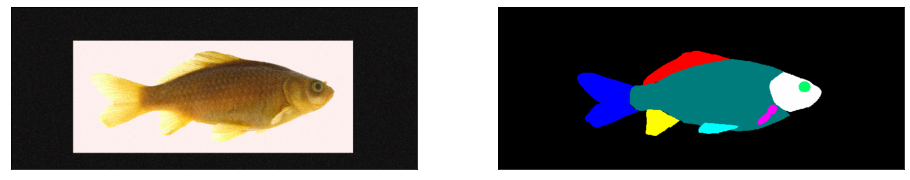

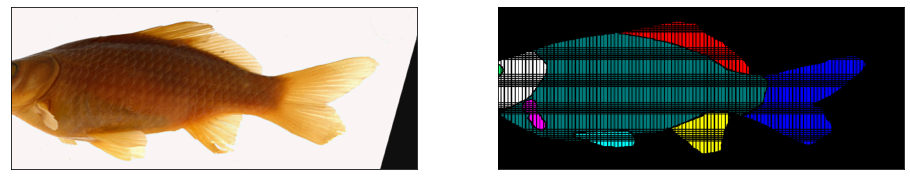

In [11]:
# temporary dataset variable
# we will look at the training set
augmented_dataset = Dataset(x_train_dir,
                            y_train_dir,
                            augmentation = get_training_augmentation(),
                            classes = ['dorsal', 'adipose', 'caudal', 'anal', 
                                       'pelvic', 'pectoral', 'head', 'eye', 
                                       'caudal-ray', 'alt-ray', 'alt-spine', 'trunk'],
                           )

for i in range(2):
    image, mask = augmented_dataset[1]
    plot_double_image(image, get_color_img(mask))


#### Pretrained Model

In [12]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['dorsal', 'adipose', 'caudal', 'anal', 
           'pelvic', 'pectoral', 'head', 'eye', 
           'caudal-ray', 'alt-ray', 'alt-spine', 'trunk']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda:4'

In [13]:
# segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name = ENCODER,
    encoder_weights = ENCODER_WEIGHTS,
    classes = len(CLASSES),
    activation = ACTIVATION,
)

In [14]:
# preprocessing function for this encoder
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Preprocessing

In [15]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation = get_training_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

#### Loader, Optimizer, Loss

In [16]:
# loading data from the dataset
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle=True, num_workers = 12)
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle=False, num_workers = 4)
test_loader = DataLoader(test_dataset)

# optimizers
optimizer = torch.optim.Adam([
    dict(params = model.parameters(), lr = 0.0001),
])

# loss = dice lose, metric = iou_score
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5)
]

#### Iterators for DataLoaders

In [17]:
# iterator/ epoch runner

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss = loss,
    metrics = metrics,
    optimizer = optimizer,
    device = DEVICE,
    verbose = True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss = loss,
    metrics = metrics,
    device = DEVICE,
    verbose = True,
)


#### Training

In [18]:
# # We will train the model for 120 epochs
 max_score = 0

 for i in range(0, 120):
    
     print('\nEpoch: {}'.format(i))
     train_logs = train_epoch.run(train_loader)
     valid_logs = valid_epoch.run(valid_loader)
    
     # to save model
     if max_score < valid_logs['iou_score']:
         max_score = valid_logs['iou_score']
         torch.save(model, 'saved_models/best_model_random.pth')
         print('Model saved!')
        
     # step wise loss function
     # lr changed after 25 epochs
    
     if i == 25:
         optimizer.param_groups[0]['lr'] = 1e-5
         print('Decrease decoder learning rate to 1e-5')

#### Iterator for test data

In [19]:
best_model = torch.load('saved_models/best_model_random.pth')

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss = loss,
    metrics = metrics,
    device = DEVICE,
)

#### Test Result

In [20]:
test_log = test_epoch.run(test_loader)
print('IOU Score: {}'.format(test_log['iou_score']))

valid: 100%|██████████| 99/99 [00:08<00:00, 12.24it/s, dice_loss - 0.05182, iou_score - 0.9062]
IOU Score: 0.9061621830920982


#### Test prediction visualization

In [21]:
# test_dataset = Dataset(
#     x_test_dir,
#     y_test_dir,
#     augmentation = get_validation_augmentation(),
#     preprocessing = get_preprocessing(preprocessing_fn),
#     classes = CLASSES,
# )

test_dataset_viz = Dataset(
    x_test_dir,
    masks_dir=None,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing_unlabeled(preprocessing_fn),
    classes = CLASSES,
)

In [22]:
# Test ouput names
test_names = read_file('test_imgs.txt')
# print(test_names)

legend_img = Image.open('Legends.png')
w_legend, h_legend = legend_img.size
ar = w_legend/h_legend

In [23]:
num_test_img = len(test_dataset)

In [29]:
import torch.functional as F


In [30]:
def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs


def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x


def iou(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Intersection over Union between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    union = torch.sum(gt) + torch.sum(pr) - intersection + eps
    return (intersection + eps) / union


jaccard = iou


def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate F-score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


def accuracy(pr, gt, threshold=0.5, ignore_channels=None):
    """Calculate accuracy score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt == pr, dtype=pr.dtype)
    score = tp / gt.view(-1).shape[0]
    return score


def precision(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate precision score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp

    score = (tp + eps) / (tp + fp + eps)

    return score


def recall(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Recall between ground truth and prediction
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: recall score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fn = torch.sum(gt) - tp

    score = (tp + eps) / (tp + fn + eps)

    return score

In [34]:
for test_no in range(num_test_img):
    
    # This image is for visualizing the groundtruth
    image_viz, mask_viz = test_dataset_viz[test_no]
    
    # This image is for model prediction
    # Reason: no need to do preprocessing again
    image, mask = test_dataset[test_no]
    
#     image_arr = image_viz.transpose(2, 0, 1).astype('float32')
    
    img_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     img_tensor = img_tensor.permute(0, 3, 1, 2).astype('float32')
    pred_mask = best_model.predict(img_tensor)
    pred_mask = pred_mask.squeeze().cpu().numpy().round()
    
    iou_ = iou(pr=torch.from_numpy(pred_mask).to(DEVICE), 
               gt=torch.from_numpy(mask).to(DEVICE))
    print(iou_.data.cpu().numpy())
    
    print(np.unique(pred_mask))
    
    print(image.shape)
    print(img_tensor.shape)
    
#     input_img = Image.fromarray(image_viz)
    
#     new_h = input_img.size[1]
#     legend = legend_img.resize((int(new_h*ar), new_h), Image.ANTIALIAS)
    break
#     get_concat_h(
#         get_concat_h(
#             Image.fromarray(image_viz),
#             get_concat_h(
#                 get_color_img(mask, normal=False), get_color_img(pred_mask, normal=False)
#             )
#         ), 
#         legend
#     ).save('single_model_test_img/'+test_names[test_no])
    

0.9404807
[0. 1.]
(3, 320, 800)
torch.Size([1, 3, 320, 800])


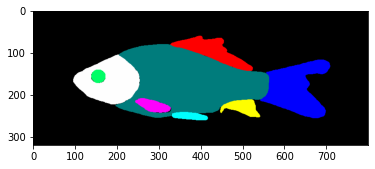

In [35]:
plt.imshow(get_color_img(pred_mask, normal=False))
plt.show()